# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.api as sm
from fbprophet import Prophet
from pandas.plotting import lag_plot
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

Importing plotly failed. Interactive plots will not work.


# Case 1

In [2]:
df = pd.read_csv('TFP.csv')

In [3]:
df

,isocode,year,rtfpna
0,USA,1950,0.617148
1,USA,1951,0.629588
2,USA,1952,0.638451
3,USA,1953,0.651858
4,USA,1954,0.646179
...,...,...,...
181,MEX,2007,1.013673
182,MEX,2008,0.991548
183,MEX,2009,0.915879
184,MEX,2010,0.941604


In [4]:
mask1 = df['isocode'] == 'USA'
mask2 = df['isocode'] == 'CAN'
mask3 = df['isocode'] == 'MEX'

In [5]:
df_usa = df[mask1].drop(columns=['isocode'])
df_can = df[mask2].drop(columns=['isocode'])
df_mex = df[mask3].drop(columns=['isocode'])

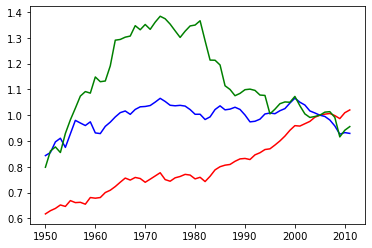

In [6]:
plt.plot(df_usa['year'], df_usa['rtfpna'], 'r-', df_can['year'], df_can['rtfpna'], 'blue', df_mex['year'], df_mex['rtfpna'], 'green')
plt.show()

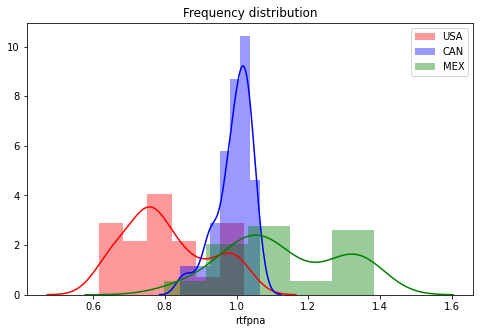

In [7]:
plt.figure(figsize=(8,5))
sns.distplot(df_usa['rtfpna'], color='red',label='USA')
sns.distplot(df_can['rtfpna'], color='blue',label='CAN')
sns.distplot(df_mex['rtfpna'], color='green',label='MEX')
plt.legend()
plt.title('Frequency distribution')
#plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.show()

## Forecast

In [8]:
df_usa = df_usa.rename({'year':'ds','rtfpna':'y'},axis=1)
df_can = df_can.rename({'year':'ds','rtfpna':'y'},axis=1)
df_mex = df_mex.rename({'year':'ds','rtfpna':'y'},axis=1)

In [9]:
df_usa.ds = pd.to_datetime(df_usa.ds, format='%Y')
df_can.ds = pd.to_datetime(df_can.ds, format='%Y')
df_mex.ds = pd.to_datetime(df_mex.ds, format='%Y')

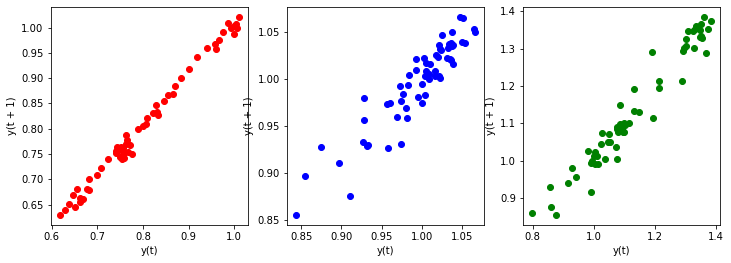

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))
lag_plot(df_usa['y'], c='red', ax = ax[0])
lag_plot(df_can['y'], c='blue', ax = ax[1])
lag_plot(df_mex['y'], c='green', ax = ax[2])

No lag plot, podemos verificar se existe uma relação entre o período anterior com o período seguinte.

USA: Podemos dizer que existe uma certa relação entre o período anterior com o período seguinte mais forte do que os demais países que estamos analisando.

CAN: No caso do Canadá, podemos dizer que 

### USA

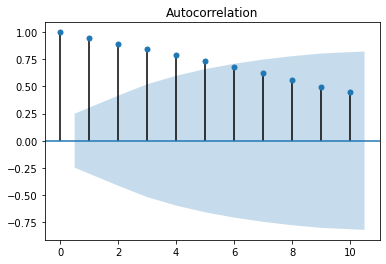

In [12]:
plot_acf(x=df_usa.y, lags=10);

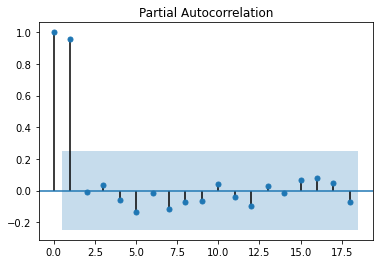

In [13]:
plot_pacf(x=df_usa.y);

Decomposing a time series into:
    
- Mean
- Trends
- Seasonal Effects
- Noise

In [14]:
res = sm.tsa.seasonal_decompose(df_usa['y'], period=6)
observed = res.observed
seasonal = res.seasonal
residual = res.resid
trend = res.trend

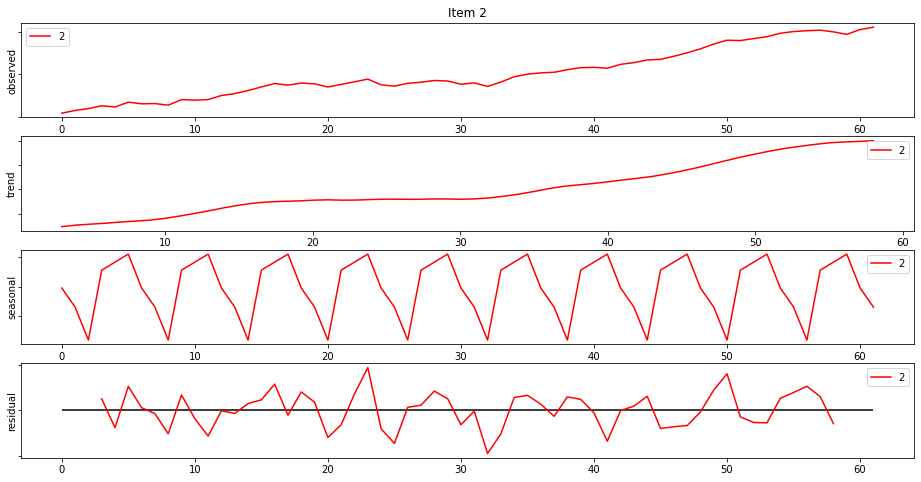

In [15]:
df_res_02 = pd.DataFrame({"observed":observed,"trend":trend, "seasonal":seasonal,"residual":residual})
plt.figure(figsize=(16,8))

plt.subplot(411)
sns.lineplot(x=df_res_02.index,y='observed',data=df_res_02,label='2',color ='red')
plt.title('Item 2')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(412)
sns.lineplot(x=df_res_02.index,y='trend',data=df_res_02,label='2',color ='red')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(413)
sns.lineplot(x=df_res_02.index,y='seasonal',data=df_res_02,label='2',color ='red')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.subplot(414)
sns.lineplot(x=df_res_02.index,y='residual',data=df_res_02,label='2',color ='red')
plt.tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)
plt.hlines(y=0,xmin=df_res_02.index.min(),xmax=df_res_02.index.max())
plt.show()

In [16]:
adfuller(df_usa['y'], autolag='AIC', regression='ct')

(-1.4149604461402028,
 0.856467046010545,
 0,
 61,
 {'1%': -4.115412397821844,
  '5%': -3.485092052154145,
  '10%': -3.170590307779065},
 -302.65363491879026)

- p-value (neste não pode rejeitar que a times series é estacionária) #ver isso
- 

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


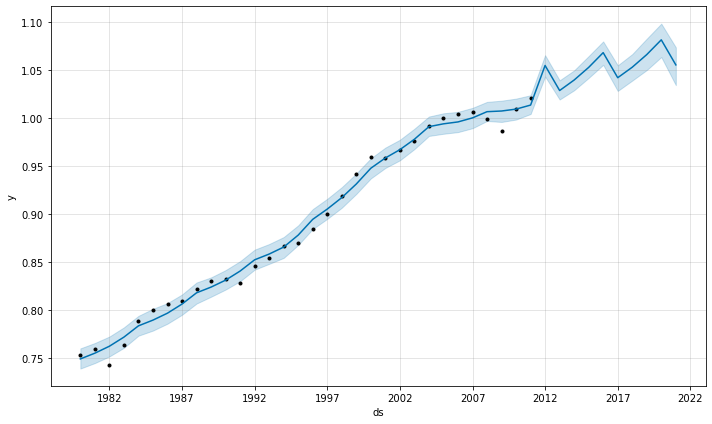

In [17]:
model = Prophet(changepoint_range=1)
model.fit(df_usa.iloc[30:,:])
future = model.make_future_dataframe(periods=10,freq='Y')
forecast = model.predict(future)
forecast_plot = model.plot(forecast)
#components_plot_forecast = model.plot_components(forecast)

In [18]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1980-01-01,0.147045,0.738774,0.759783,0.147045,0.147045,0.601768,0.601768,0.601768,0.601768,0.601768,0.601768,0.0,0.0,0.0,0.748813
1,1981-01-01,0.155679,0.744510,0.765416,0.155679,0.155679,0.599128,0.599128,0.599128,0.599128,0.599128,0.599128,0.0,0.0,0.0,0.754807
2,1982-01-01,0.164290,0.751428,0.772137,0.164290,0.164290,0.597767,0.597767,0.597767,0.597767,0.597767,0.597767,0.0,0.0,0.0,0.762058
3,1983-01-01,0.172901,0.760423,0.781701,0.172901,0.172901,0.598647,0.598647,0.598647,0.598647,0.598647,0.598647,0.0,0.0,0.0,0.771548
4,1984-01-01,0.181512,0.773027,0.793662,0.181512,0.181512,0.601768,0.601768,0.601768,0.601768,0.601768,0.601768,0.0,0.0,0.0,0.783280
5,1985-01-01,0.190146,0.778371,0.801035,0.190146,0.190146,0.599128,0.599128,0.599128,0.599128,0.599128,0.599128,0.0,0.0,0.0,0.789274
6,1986-01-01,0.198742,0.785570,0.807003,0.198742,0.198742,0.597767,0.597767,0.597767,0.597767,0.597767,0.597767,0.0,0.0,0.0,0.796509
7,1987-01-01,0.207337,0.794838,0.815966,0.207337,0.207337,0.598647,0.598647,0.598647,0.598647,0.598647,0.598647,0.0,0.0,0.0,0.805984
8,1988-01-01,0.215931,0.806512,0.828446,0.215931,0.215931,0.601768,0.601768,0.601768,0.601768,0.601768,0.601768,0.0,0.0,0.0,0.817699
9,1989-01-01,0.224549,0.813642,0.833801,0.224549,0.224549,0.599128,0.599128,0.599128,0.599128,0.599128,0.599128,0.0,0.0,0.0,0.823677
